# MLP
Like MLP_269 but run on every cell line individually.

In [1]:

from datetime import datetime
print(datetime.now())

2023-04-19 17:35:15.094297


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
# EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_269'

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.all_cell_lines.csv'
RCI_FILE_TEST  = 'test.lncRNA_RCI.all_cell_lines.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    string = fields[cell_line]
                    if string != 'nan':
                        value = float(string)
                        self.gene2rci[gene_id] = value
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-19 17:35:49.531272
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131328    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 143,809
Trainab

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = -1 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd)  # no validation )
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

In [11]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)




2023-04-19 17:35:50.586405
Cell Line 0 A549
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1630
Num RCI: 1630
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 1630 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 387
Num RCI: 387
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 387 sequences.

Training # 1 1
2023-04-19 17:36:00.407609
2023-04-19 17:36:00.407676
Discriminator is GMM
Means [-2.113043835924107, 0.3824423335786255]
Variances [1.37313111 1.19222998]
Priors [0.36515146 0.63484854]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 1082:548 66.38%
Computed cla

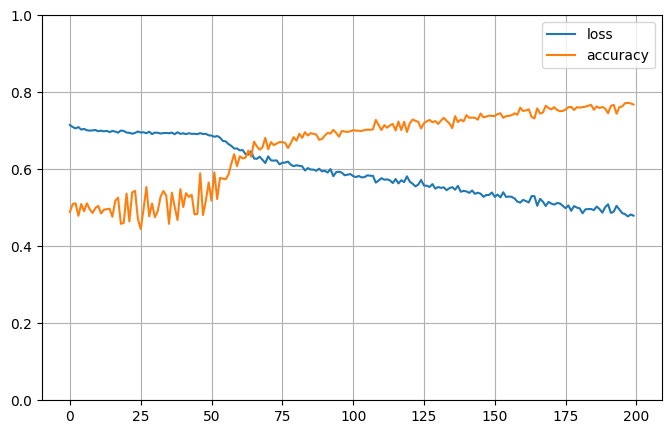


Testing # 1 1
2023-04-19 17:37:26.708945
2023-04-19 17:37:26.709006
PREDICT
2023-04-19 17:37:26.714511
Test 1:0 246:141 63.57%
Predict 1:0 215:172 55.56%
Test sizes (387, 1025) (387,)
Distrib of scores: 0.5114915 mean 0.2853874 std
Range of scores: 0.0035619151 to 0.9917119
Score threshold 0.5
Confusion matrix
 [[ 87  54]
 [ 85 161]]
Normalized matrix
 [[0.2248062  0.13953488]
 [0.21963824 0.41602067]]
Extreme scores correct, pos:neg 115 74
Extreme scores incorrect pos:neg 35 63


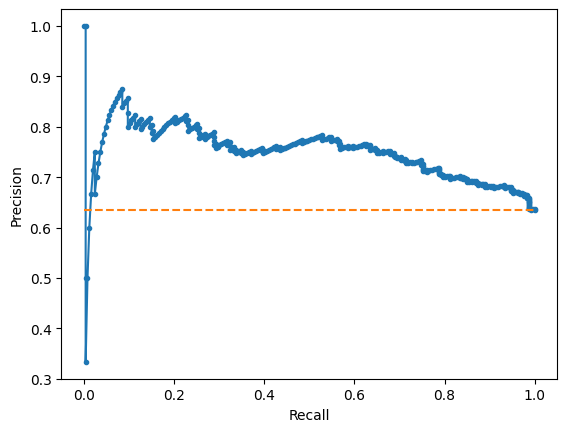

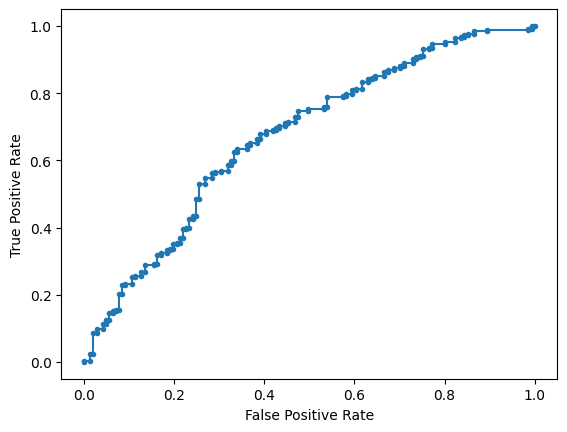

Accuracy: 64.08% Precision: 74.88% Recall: 65.45%
F1: 69.85% MCC: 0.2629
AUPRC: 75.00% AUROC: 67.17%
 accuracy [64.08268733850129]
 precision [74.88372093023256]
 recall [65.4471544715447]
 F1 [69.84815618221258]
 MCC [0.26293718382195796]
 AUPRC [75.00367034635748]
 AUROC [67.17407599607913]
 accuracy mean 64.08% std nan
 precision mean 74.88% std nan
 recall mean 65.45% std nan
 F1 mean 69.85% std nan
 MCC mean 0.2629 std nan
 AUPRC mean 75.00% std nan
 AUROC mean 67.17% std nan
 accuracy [[64.08268733850129]]
 precision [[74.88372093023256]]
 recall [[65.4471544715447]]
 F1 [[69.84815618221258]]
 MCC [[0.26293718382195796]]
 AUPRC [[75.00367034635748]]
 AUROC [[67.17407599607913]]

2023-04-19 17:37:27.411183
Cell Line 1 H1.hESC
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 2982
Num RCI: 2982
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.c

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 2982 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 728
Num RCI: 728
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 728 sequences.

Training # 1 1
2023-04-19 17:37:33.730851
2023-04-19 17:37:33.730920
Discriminator is GMM
Means [0.40146284378281777, -1.4482882755188413]
Variances [1.55005853 1.57888046]
Priors [0.56137863 0.43862137]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1768:1214 59.29%
Computed class weights: {0: 1.228171334431631, 1: 0.8433257918552036}
FIT
2023-04-19 17:37:38.537129


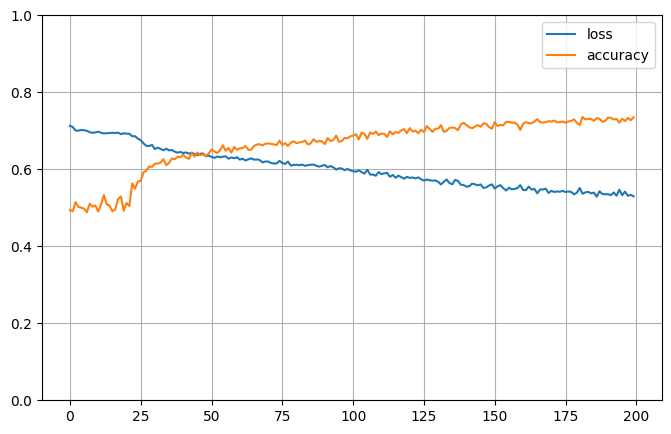


Testing # 1 1
2023-04-19 17:40:01.876468
2023-04-19 17:40:01.876977
PREDICT
2023-04-19 17:40:01.884165
Test 1:0 426:302 58.52%
Predict 1:0 330:398 45.33%
Test sizes (728, 1025) (728,)
Distrib of scores: 0.4639047 mean 0.25531492 std
Range of scores: 0.0057395534 to 0.9933122
Score threshold 0.5
Confusion matrix
 [[208  94]
 [190 236]]
Normalized matrix
 [[0.28571429 0.12912088]
 [0.26098901 0.32417582]]
Extreme scores correct, pos:neg 151 143
Extreme scores incorrect pos:neg 58 122


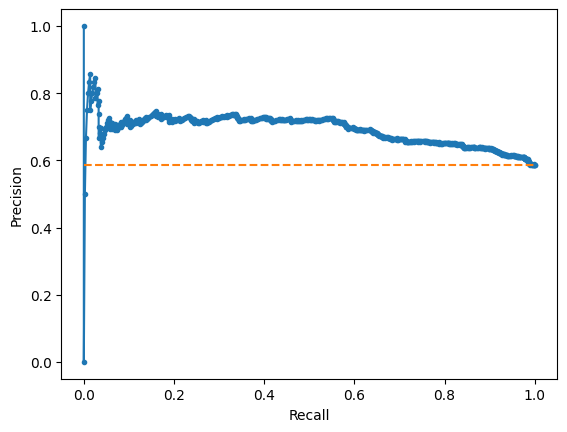

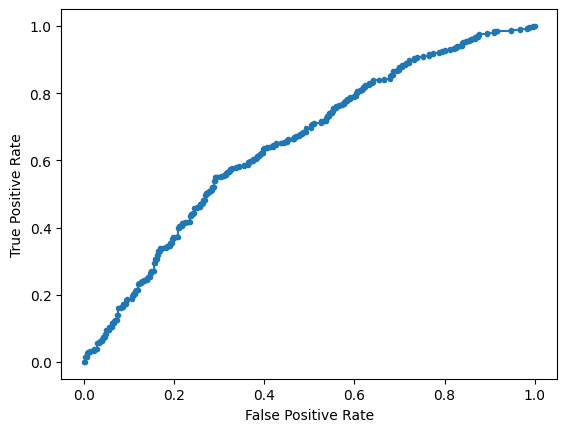

Accuracy: 60.99% Precision: 71.52% Recall: 55.40%
F1: 62.43% MCC: 0.2402
AUPRC: 69.09% AUROC: 65.02%
 accuracy [60.98901098901099]
 precision [71.51515151515152]
 recall [55.39906103286385]
 F1 [62.43386243386243]
 MCC [0.24023561586484218]
 AUPRC [69.08645682043483]
 AUROC [65.01881043435004]
 accuracy mean 60.99% std nan
 precision mean 71.52% std nan
 recall mean 55.40% std nan
 F1 mean 62.43% std nan
 MCC mean 0.2402 std nan
 AUPRC mean 69.09% std nan
 AUROC mean 65.02% std nan
 accuracy [[60.98901098901099]]
 precision [[71.51515151515152]]
 recall [[55.39906103286385]]
 F1 [[62.43386243386243]]
 MCC [[0.24023561586484218]]
 AUPRC [[69.08645682043483]]
 AUROC [[65.01881043435004]]

2023-04-19 17:40:02.808549
Cell Line 2 HeLa.S3
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1008
Num RCI: 1008
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1008 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 239
Num RCI: 239
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 239 sequences.

Training # 1 1
2023-04-19 17:40:05.091747
2023-04-19 17:40:05.091997
Discriminator is GMM
Means [-0.4164065766455784, -2.818421831978961]
Variances [1.90070251 2.04342939]
Priors [0.53260615 0.46739385]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 556:452 55.16%
Computed class weights: {0: 1.1150442477876106, 1: 0.9064748201438849}
FIT
2023-04-19 17:40:08.401580


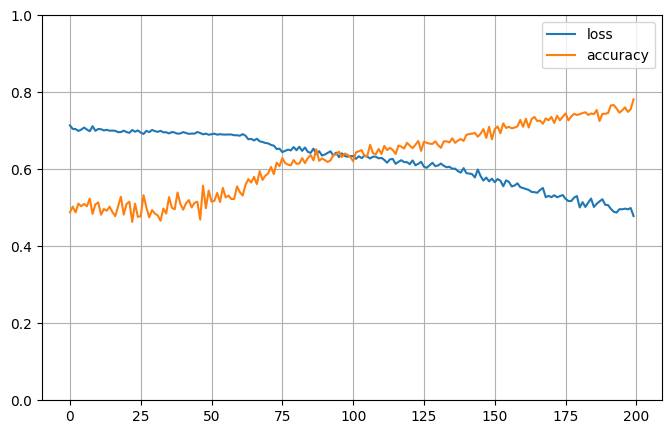


Testing # 1 1
2023-04-19 17:40:44.497036
2023-04-19 17:40:44.497095
PREDICT
2023-04-19 17:40:44.504379
Test 1:0 115:124 48.12%
Predict 1:0 108:131 45.19%
Test sizes (239, 1025) (239,)
Distrib of scores: 0.43941048 mean 0.26674306 std
Range of scores: 0.016500583 to 0.96174777
Score threshold 0.5
Confusion matrix
 [[79 45]
 [52 63]]
Normalized matrix
 [[0.33054393 0.18828452]
 [0.21757322 0.26359833]]
Extreme scores correct, pos:neg 32 68
Extreme scores incorrect pos:neg 31 35


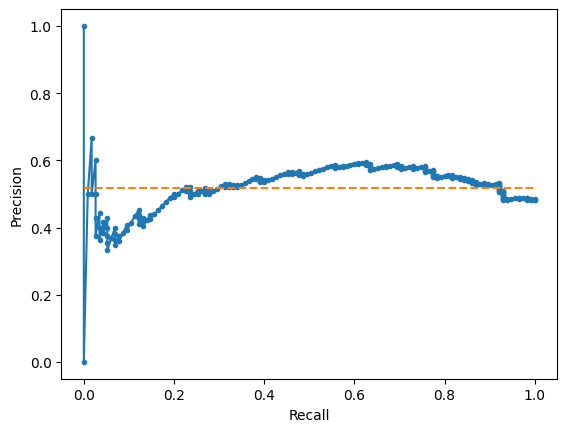

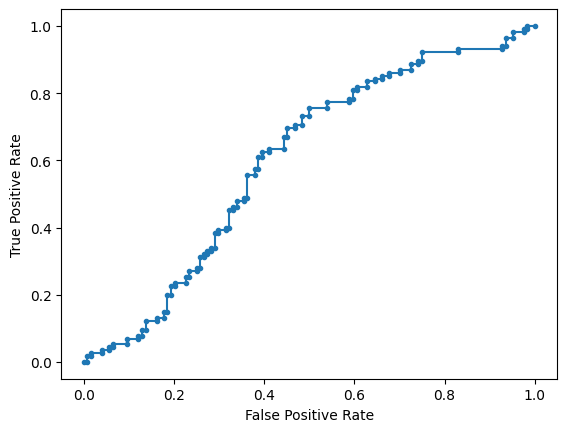

Accuracy: 59.41% Precision: 58.33% Recall: 54.78%
F1: 56.50% MCC: 0.1857
AUPRC: 52.13% AUROC: 60.16%
 accuracy [59.41422594142259]
 precision [58.333333333333336]
 recall [54.78260869565217]
 F1 [56.502242152466366]
 MCC [0.18565337191090728]
 AUPRC [52.1268267150525]
 AUROC [60.16129032258064]
 accuracy mean 59.41% std nan
 precision mean 58.33% std nan
 recall mean 54.78% std nan
 F1 mean 56.50% std nan
 MCC mean 0.1857 std nan
 AUPRC mean 52.13% std nan
 AUROC mean 60.16% std nan
 accuracy [[59.41422594142259]]
 precision [[58.333333333333336]]
 recall [[54.78260869565217]]
 F1 [[56.502242152466366]]
 MCC [[0.18565337191090728]]
 AUPRC [[52.1268267150525]]
 AUROC [[60.16129032258064]]

2023-04-19 17:40:45.118999
Cell Line 3 HepG2
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1516
Num RCI: 1516
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1516 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 383
Num RCI: 383
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 383 sequences.

Training # 1 1
2023-04-19 17:40:50.339106
2023-04-19 17:40:50.339545
Discriminator is GMM
Means [-3.0277815228385685, -0.20664239362691122]
Variances [2.56504726 1.66709545]
Priors [0.42795125 0.57204875]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 915:601 60.36%
Computed class weights: {0: 1.2612312811980033, 1: 0.8284153005464481}
FIT
2023-04-19 17:40:52.088615


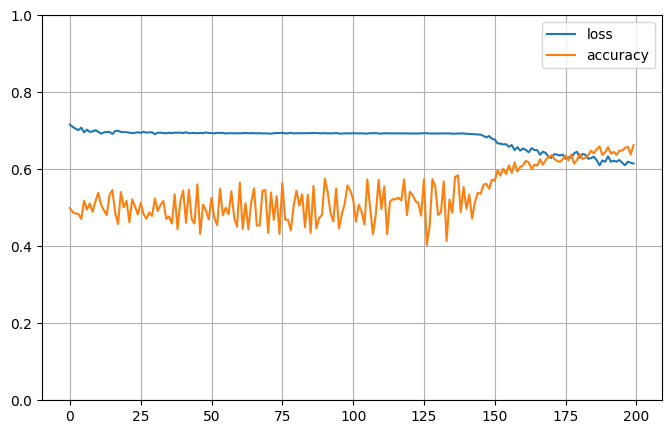


Testing # 1 1
2023-04-19 17:42:15.481270
2023-04-19 17:42:15.482296
PREDICT
2023-04-19 17:42:15.485784
Test 1:0 226:157 59.01%
Predict 1:0 146:237 38.12%
Test sizes (383, 1025) (383,)
Distrib of scores: 0.44785032 mean 0.17370307 std
Range of scores: 0.11128186 to 0.87444216
Score threshold 0.5
Confusion matrix
 [[121  36]
 [116 110]]
Normalized matrix
 [[0.31592689 0.09399478]
 [0.30287206 0.28720627]]
Extreme scores correct, pos:neg 44 72
Extreme scores incorrect pos:neg 11 57


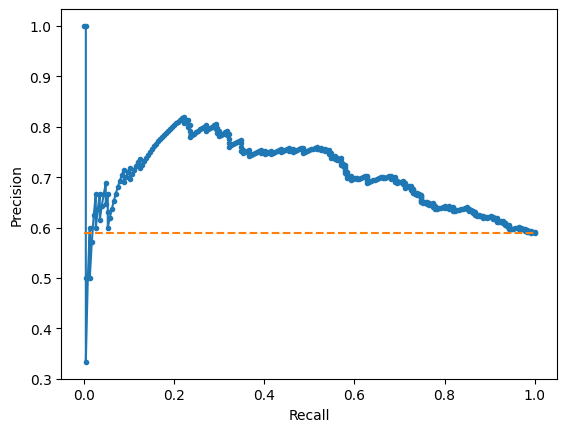

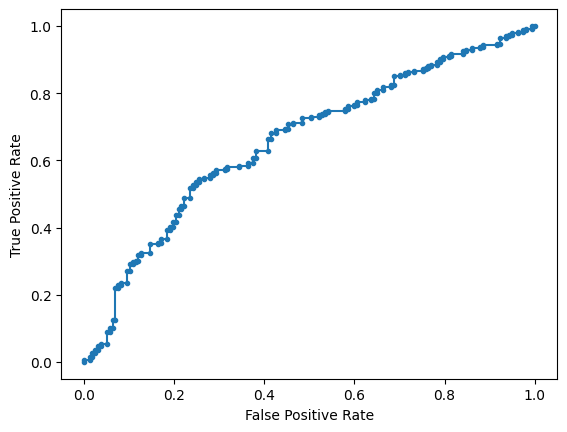

Accuracy: 60.31% Precision: 75.34% Recall: 48.67%
F1: 59.14% MCC: 0.2607
AUPRC: 70.51% AUROC: 65.66%
 accuracy [60.313315926892955]
 precision [75.34246575342466]
 recall [48.67256637168141]
 F1 [59.13978494623655]
 MCC [0.2606791886428101]
 AUPRC [70.51452229461638]
 AUROC [65.66146214982244]
 accuracy mean 60.31% std nan
 precision mean 75.34% std nan
 recall mean 48.67% std nan
 F1 mean 59.14% std nan
 MCC mean 0.2607 std nan
 AUPRC mean 70.51% std nan
 AUROC mean 65.66% std nan
 accuracy [[60.313315926892955]]
 precision [[75.34246575342466]]
 recall [[48.67256637168141]]
 F1 [[59.13978494623655]]
 MCC [[0.2606791886428101]]
 AUPRC [[70.51452229461638]]
 AUROC [[65.66146214982244]]

2023-04-19 17:42:16.130676
Cell Line 4 HT1080
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1025
Num RCI: 1025
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1025 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 262
Num RCI: 262
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 262 sequences.

Training # 1 1
2023-04-19 17:42:18.892671
2023-04-19 17:42:18.892734
Discriminator is GMM
Means [-2.151948974499462, 0.41825457993226073]
Variances [2.80568508 1.31883278]
Priors [0.38587298 0.61412702]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 686:339 66.93%
Computed class weights: {0: 1.5117994100294985, 1: 0.7470845481049563}
FIT
2023-04-19 17:42:19.674268


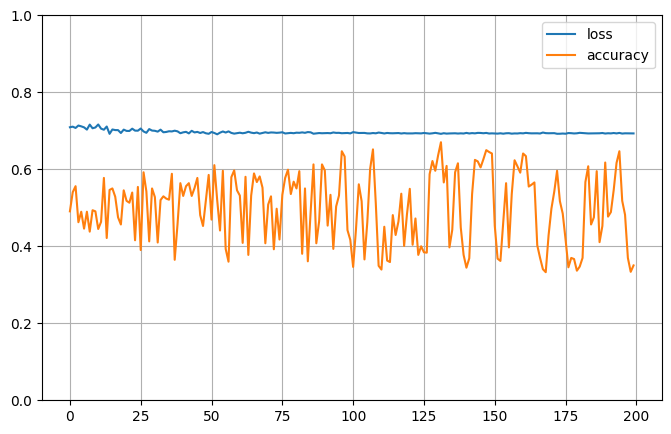


Testing # 1 1
2023-04-19 17:42:57.601469
2023-04-19 17:42:57.602148
PREDICT
2023-04-19 17:42:57.605255
Test 1:0 177:85 67.56%
Predict 1:0 0:262  0.00%
Test sizes (262, 1025) (262,)
Distrib of scores: 0.49367163 mean 2.4224519e-05 std
Range of scores: 0.49360478 to 0.4937807
Score threshold 0.5
Confusion matrix
 [[ 85   0]
 [177   0]]
Normalized matrix
 [[0.32442748 0.        ]
 [0.67557252 0.        ]]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


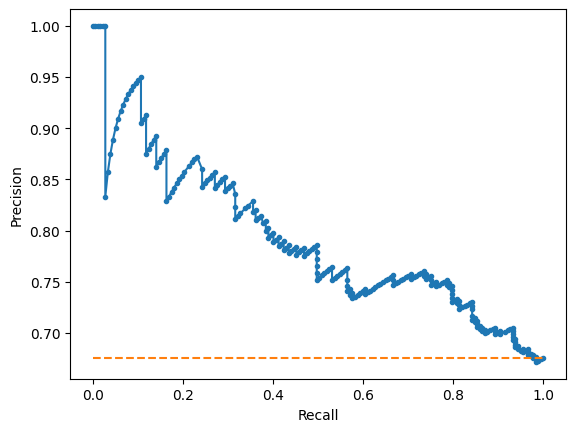

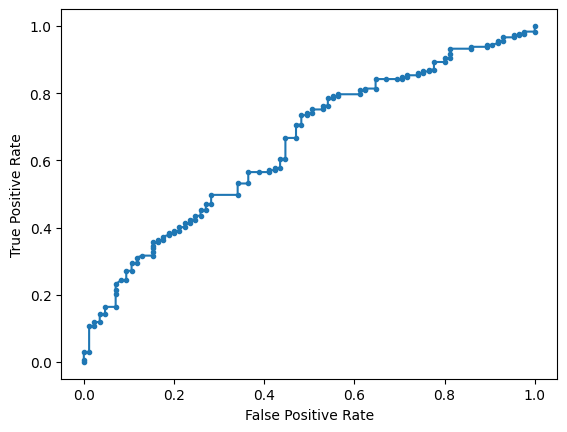

Accuracy: 32.44% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.0000
AUPRC: 79.19% AUROC: 64.70%
 accuracy [32.44274809160305]
 precision [0.0]
 recall [0.0]
 F1 [0.0]
 MCC [0.0]
 AUPRC [79.18735726144455]
 AUROC [64.69591226321036]
 accuracy mean 32.44% std nan
 precision mean 0.00% std nan
 recall mean 0.00% std nan
 F1 mean 0.00% std nan
 MCC mean 0.0000 std nan
 AUPRC mean 79.19% std nan
 AUROC mean 64.70% std nan
 accuracy [[32.44274809160305]]
 precision [[0.0]]
 recall [[0.0]]
 F1 [[0.0]]
 MCC [[0.0]]
 AUPRC [[79.18735726144455]]
 AUROC [[64.69591226321036]]

2023-04-19 17:42:58.237728
Cell Line 5 HUVEC
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1680
Num RCI: 1680
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1680 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 408
Num RCI: 408
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 408 sequences.

Training # 1 1
2023-04-19 17:43:02.018838
2023-04-19 17:43:02.018907
Discriminator is GMM
Means [-0.13561061104225194, -3.1148435538351538]
Variances [1.89858956 2.52809231]
Priors [0.57830047 0.42169953]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 1027:653 61.13%
Computed class weights: {0: 1.2863705972434916, 1: 0.8179162609542356}
FIT
2023-04-19 17:43:02.950114


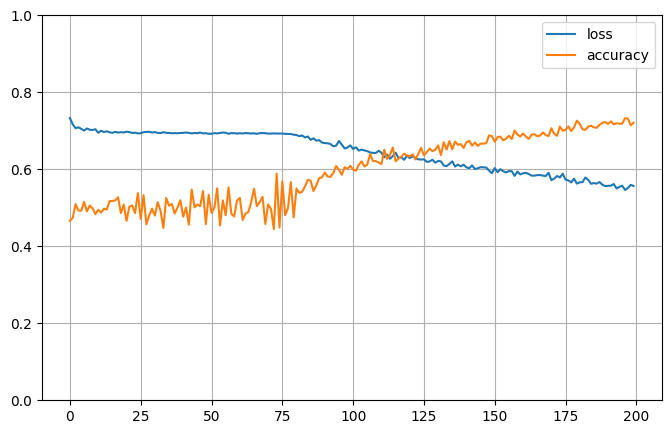


Testing # 1 1
2023-04-19 17:44:01.267165
2023-04-19 17:44:01.267681
PREDICT
2023-04-19 17:44:01.272432
Test 1:0 243:165 59.56%
Predict 1:0 217:191 53.19%
Test sizes (408, 1025) (408,)
Distrib of scores: 0.50096405 mean 0.22842215 std
Range of scores: 0.0017414362 to 0.91421074
Score threshold 0.5
Confusion matrix
 [[102  63]
 [ 89 154]]
Normalized matrix
 [[0.25       0.15441176]
 [0.21813725 0.37745098]]
Extreme scores correct, pos:neg 93 69
Extreme scores incorrect pos:neg 35 41


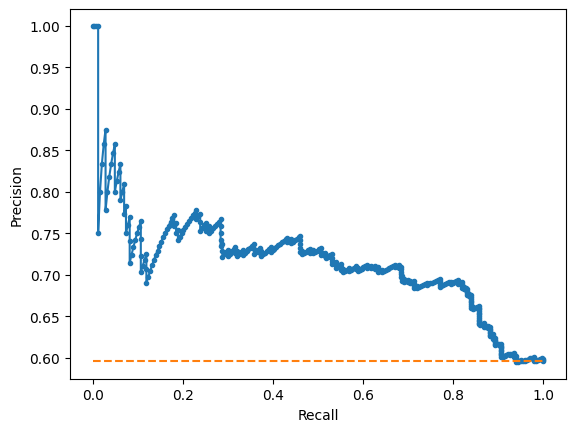

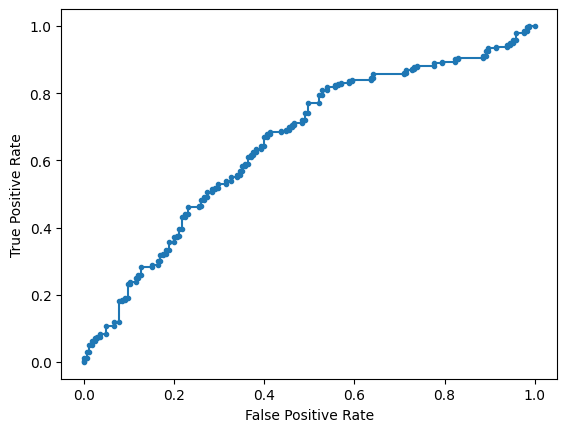

Accuracy: 62.75% Precision: 70.97% Recall: 63.37%
F1: 66.96% MCC: 0.2478
AUPRC: 71.43% AUROC: 65.36%
 accuracy [62.745098039215684]
 precision [70.96774193548387]
 recall [63.37448559670782]
 F1 [66.95652173913044]
 MCC [0.24778368741744694]
 AUPRC [71.42779450169289]
 AUROC [65.36226462152389]
 accuracy mean 62.75% std nan
 precision mean 70.97% std nan
 recall mean 63.37% std nan
 F1 mean 66.96% std nan
 MCC mean 0.2478 std nan
 AUPRC mean 71.43% std nan
 AUROC mean 65.36% std nan
 accuracy [[62.745098039215684]]
 precision [[70.96774193548387]]
 recall [[63.37448559670782]]
 F1 [[66.95652173913044]]
 MCC [[0.24778368741744694]]
 AUPRC [[71.42779450169289]]
 AUROC [[65.36226462152389]]

2023-04-19 17:44:02.251654
Cell Line 6 MCF.7
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 2361
Num RCI: 2361
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 2361 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 588
Num RCI: 588
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 588 sequences.

Training # 1 1
2023-04-19 17:44:08.585779
2023-04-19 17:44:08.585893
Discriminator is GMM
Means [-3.2669503183780497, -0.1445817540767038]
Variances [2.62061738 2.19280847]
Priors [0.46079175 0.53920825]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 1308:1053 55.40%
Computed class weights: {0: 1.121082621082621, 1: 0.9025229357798165}
FIT
2023-04-19 17:44:09.514663


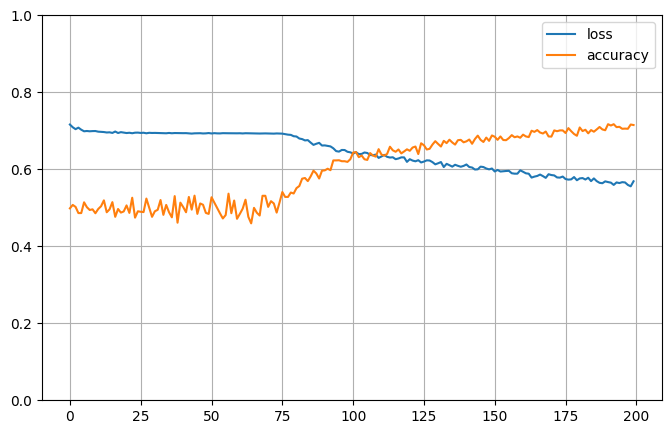


Testing # 1 1
2023-04-19 17:45:32.785838
2023-04-19 17:45:32.785889
PREDICT
2023-04-19 17:45:32.789452
Test 1:0 344:244 58.50%
Predict 1:0 305:283 51.87%
Test sizes (588, 1025) (588,)
Distrib of scores: 0.491466 mean 0.21060453 std
Range of scores: 0.020686174 to 0.9050249
Score threshold 0.5
Confusion matrix
 [[152  92]
 [131 213]]
Normalized matrix
 [[0.2585034  0.15646259]
 [0.22278912 0.3622449 ]]
Extreme scores correct, pos:neg 105 96
Extreme scores incorrect pos:neg 46 61


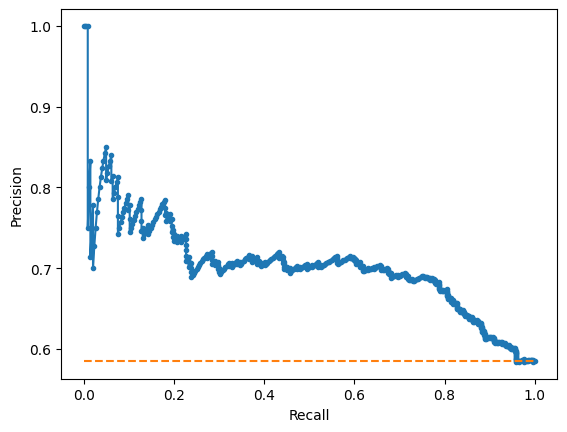

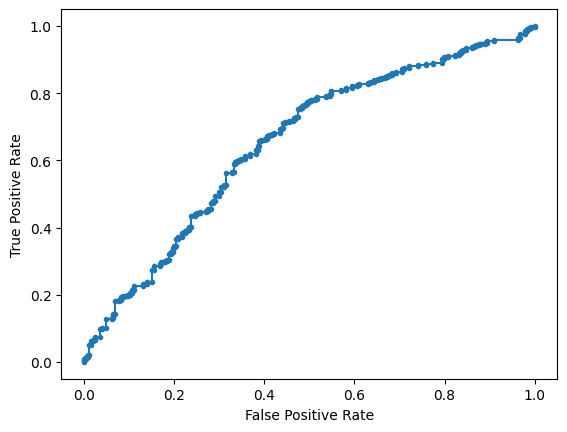

Accuracy: 62.07% Precision: 69.84% Recall: 61.92%
F1: 65.64% MCC: 0.2388
AUPRC: 70.28% AUROC: 65.30%
 accuracy [62.074829931972786]
 precision [69.83606557377048]
 recall [61.91860465116279]
 F1 [65.63944530046226]
 MCC [0.2387766827288869]
 AUPRC [70.28116108288468]
 AUROC [65.30094357605795]
 accuracy mean 62.07% std nan
 precision mean 69.84% std nan
 recall mean 61.92% std nan
 F1 mean 65.64% std nan
 MCC mean 0.2388 std nan
 AUPRC mean 70.28% std nan
 AUROC mean 65.30% std nan
 accuracy [[62.074829931972786]]
 precision [[69.83606557377048]]
 recall [[61.91860465116279]]
 F1 [[65.63944530046226]]
 MCC [[0.2387766827288869]]
 AUPRC [[70.28116108288468]]
 AUROC [[65.30094357605795]]

2023-04-19 17:45:33.421115
Cell Line 7 NCI.H460
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 695
Num RCI: 695
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 695 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 165
Num RCI: 165
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 165 sequences.

Training # 1 1
2023-04-19 17:45:35.542226
2023-04-19 17:45:35.542303
Discriminator is GMM
Means [-0.7499228329865164, -3.0108672255506024]
Variances [2.1853445  3.12369922]
Priors [0.67868669 0.32131331]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
Train 1:0 539:156 77.55%
Computed class weights: {0: 2.2275641025641026, 1: 0.6447124304267161}
FIT
2023-04-19 17:45:36.343751


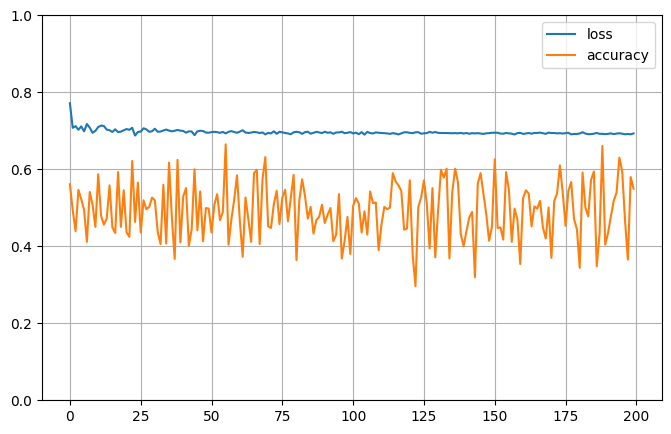


Testing # 1 1
2023-04-19 17:46:18.767948
2023-04-19 17:46:18.768009
PREDICT
2023-04-19 17:46:18.775062
Test 1:0 120:45 72.73%
Predict 1:0 99:66 60.00%
Test sizes (165, 1025) (165,)
Distrib of scores: 0.50071996 mean 0.0028992987 std
Range of scores: 0.4929523 to 0.5071615
Score threshold 0.5
Confusion matrix
 [[22 23]
 [44 76]]
Normalized matrix
 [[0.13333333 0.13939394]
 [0.26666667 0.46060606]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


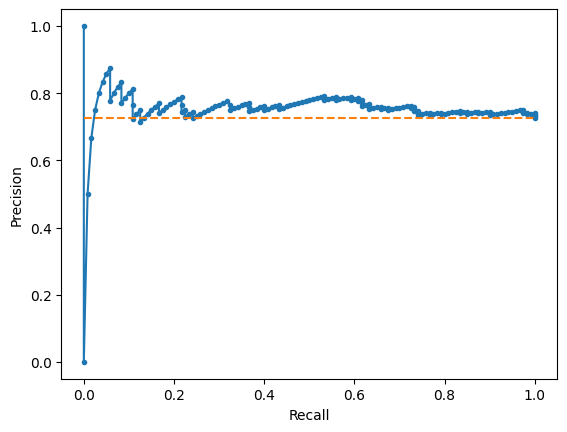

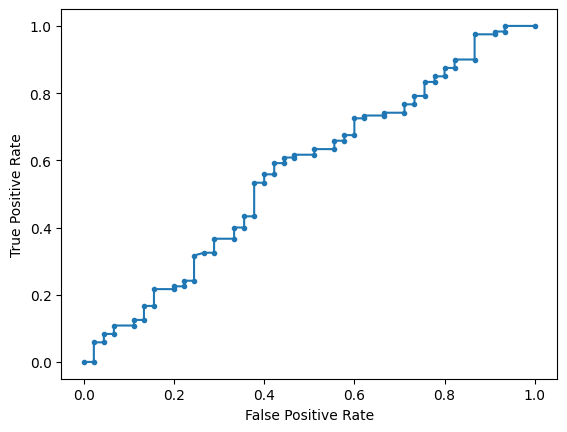

Accuracy: 59.39% Precision: 76.77% Recall: 63.33%
F1: 69.41% MCC: 0.1111
AUPRC: 75.40% AUROC: 56.47%
 accuracy [59.3939393939394]
 precision [76.76767676767676]
 recall [63.33333333333333]
 F1 [69.40639269406391]
 MCC [0.1111111111111111]
 AUPRC [75.40040957828779]
 AUROC [56.47222222222222]
 accuracy mean 59.39% std nan
 precision mean 76.77% std nan
 recall mean 63.33% std nan
 F1 mean 69.41% std nan
 MCC mean 0.1111 std nan
 AUPRC mean 75.40% std nan
 AUROC mean 56.47% std nan
 accuracy [[59.3939393939394]]
 precision [[76.76767676767676]]
 recall [[63.33333333333333]]
 F1 [[69.40639269406391]]
 MCC [[0.1111111111111111]]
 AUPRC [[75.40040957828779]]
 AUROC [[56.47222222222222]]

2023-04-19 17:46:19.887715
Cell Line 8 NHEK
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1208
Num RCI: 1208
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1208 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 288
Num RCI: 288
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 288 sequences.

Training # 1 1
2023-04-19 17:46:24.570347
2023-04-19 17:46:24.570785
Discriminator is GMM
Means [-0.18715450950521162, -2.9218121124567493]
Variances [1.59780369 3.1629524 ]
Priors [0.63329397 0.36670603]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 833:375 68.96%
Computed class weights: {0: 1.6106666666666667, 1: 0.7250900360144058}
FIT
2023-04-19 17:46:26.276883


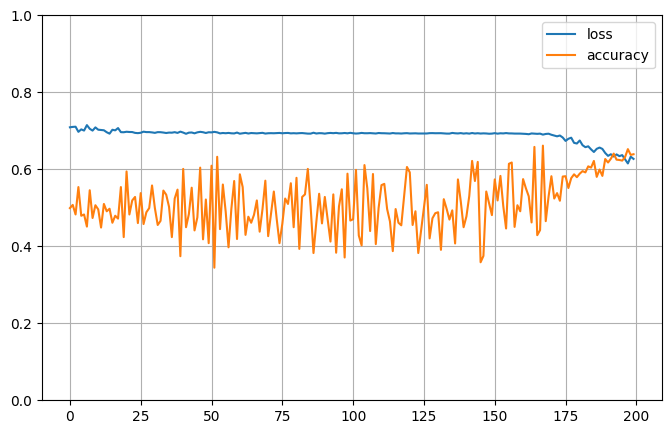


Testing # 1 1
2023-04-19 17:47:49.655116
2023-04-19 17:47:49.655167
PREDICT
2023-04-19 17:47:49.663039
Test 1:0 193:95 67.01%
Predict 1:0 196:92 68.06%
Test sizes (288, 1025) (288,)
Distrib of scores: 0.5855615 mean 0.13798738 std
Range of scores: 0.28278852 to 0.9515457
Score threshold 0.5
Confusion matrix
 [[ 43  52]
 [ 49 144]]
Normalized matrix
 [[0.14930556 0.18055556]
 [0.17013889 0.5       ]]
Extreme scores correct, pos:neg 80 4
Extreme scores incorrect pos:neg 19 8


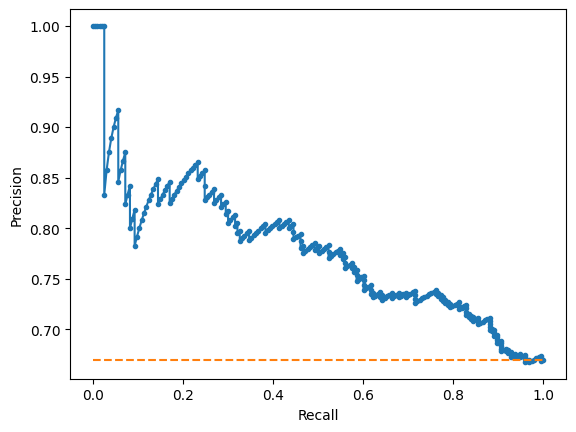

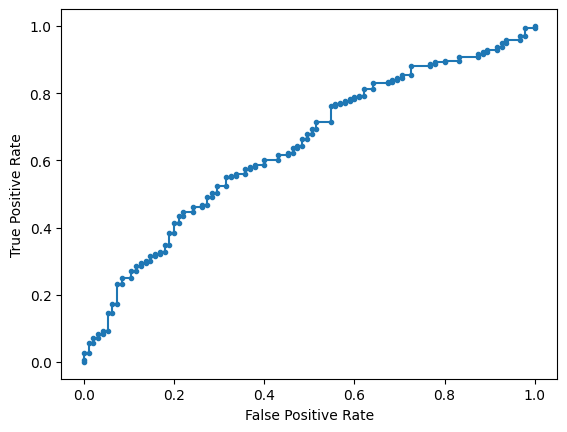

Accuracy: 64.93% Precision: 73.47% Recall: 74.61%
F1: 74.04% MCC: 0.2004
AUPRC: 77.76% AUROC: 63.97%
 accuracy [64.93055555555556]
 precision [73.46938775510205]
 recall [74.61139896373057]
 F1 [74.03598971722366]
 MCC [0.2004084189324978]
 AUPRC [77.75863644519269]
 AUROC [63.965094082356146]
 accuracy mean 64.93% std nan
 precision mean 73.47% std nan
 recall mean 74.61% std nan
 F1 mean 74.04% std nan
 MCC mean 0.2004 std nan
 AUPRC mean 77.76% std nan
 AUROC mean 63.97% std nan
 accuracy [[64.93055555555556]]
 precision [[73.46938775510205]]
 recall [[74.61139896373057]]
 F1 [[74.03598971722366]]
 MCC [[0.2004084189324978]]
 AUPRC [[77.75863644519269]]
 AUROC [[63.965094082356146]]

2023-04-19 17:47:50.285933
Cell Line 9 SK.MEL.5
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 605
Num RCI: 605
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 605 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 158
Num RCI: 158
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 158 sequences.

Training # 1 1
2023-04-19 17:47:52.091715
2023-04-19 17:47:52.091799
Discriminator is GMM
Means [-0.7005275969105765, -3.641821507007351]
Variances [2.28787762 3.84438107]
Priors [0.62812313 0.37187687]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
Train 1:0 422:183 69.75%
Computed class weights: {0: 1.6530054644808743, 1: 0.716824644549763}
FIT
2023-04-19 17:47:52.842359


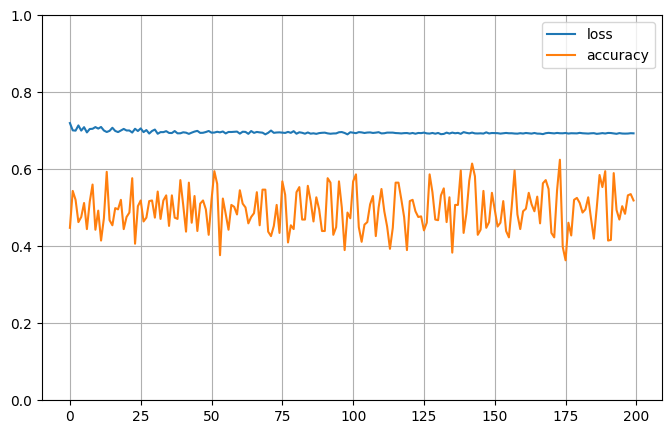


Testing # 1 1
2023-04-19 17:48:35.276318
2023-04-19 17:48:35.276377
PREDICT
2023-04-19 17:48:35.288841
Test 1:0 112:46 70.89%
Predict 1:0 0:158  0.00%
Test sizes (158, 1025) (158,)
Distrib of scores: 0.49912792 mean 0.00011820705 std
Range of scores: 0.49881506 to 0.49961287
Score threshold 0.5
Confusion matrix
 [[ 46   0]
 [112   0]]
Normalized matrix
 [[0.29113924 0.        ]
 [0.70886076 0.        ]]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


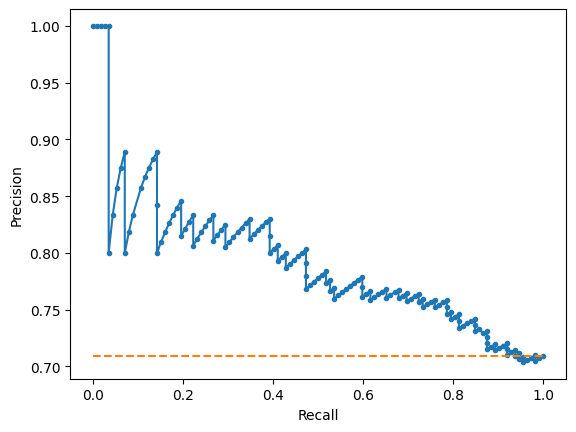

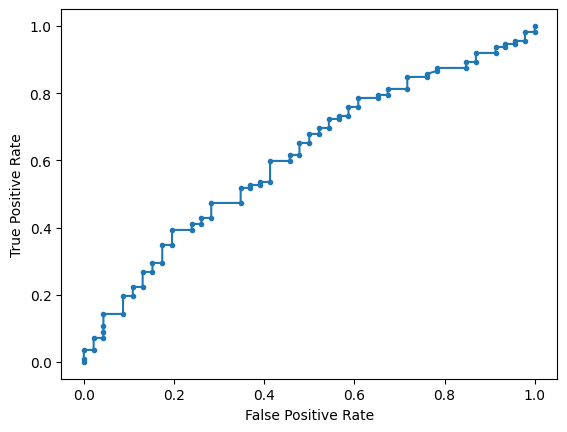

Accuracy: 29.11% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.0000
AUPRC: 79.04% AUROC: 61.15%
 accuracy [29.11392405063291]
 precision [0.0]
 recall [0.0]
 F1 [0.0]
 MCC [0.0]
 AUPRC [79.04464035344566]
 AUROC [61.151009316770185]
 accuracy mean 29.11% std nan
 precision mean 0.00% std nan
 recall mean 0.00% std nan
 F1 mean 0.00% std nan
 MCC mean 0.0000 std nan
 AUPRC mean 79.04% std nan
 AUROC mean 61.15% std nan
 accuracy [[29.11392405063291]]
 precision [[0.0]]
 recall [[0.0]]
 F1 [[0.0]]
 MCC [[0.0]]
 AUPRC [[79.04464035344566]]
 AUROC [[61.151009316770185]]

2023-04-19 17:48:35.976592
Cell Line 10 SK.N.DZ
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 677
Num RCI: 677
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 677 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 170
Num RCI: 170
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 170 sequences.

Training # 1 1
2023-04-19 17:48:40.107821
2023-04-19 17:48:40.108242
Discriminator is GMM
Means [0.019638573421281558, -2.102332474894561]
Variances [1.11014878 2.56586809]
Priors [0.70582437 0.29417563]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 540:137 79.76%
Computed class weights: {0: 2.4708029197080292, 1: 0.6268518518518519}
FIT
2023-04-19 17:48:41.904674


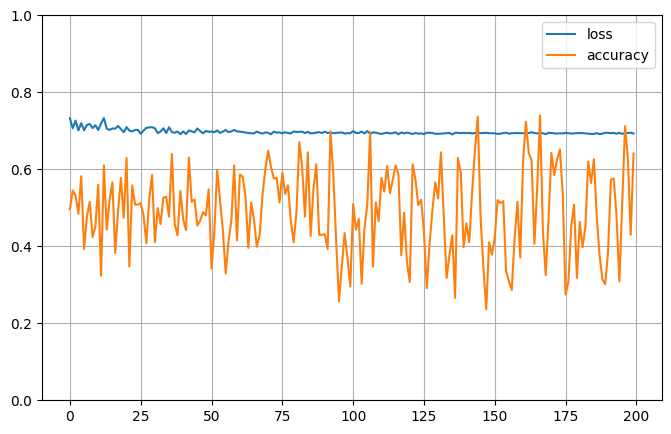


Testing # 1 1
2023-04-19 17:49:08.442645
2023-04-19 17:49:08.442698
PREDICT
2023-04-19 17:49:08.451570
Test 1:0 128:42 75.29%
Predict 1:0 170:0 100.00%
Test sizes (170, 1025) (170,)
Distrib of scores: 0.50594413 mean 0.0006906634 std
Range of scores: 0.5041425 to 0.50764763
Score threshold 0.5
Confusion matrix
 [[  0  42]
 [  0 128]]
Normalized matrix
 [[0.         0.24705882]
 [0.         0.75294118]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


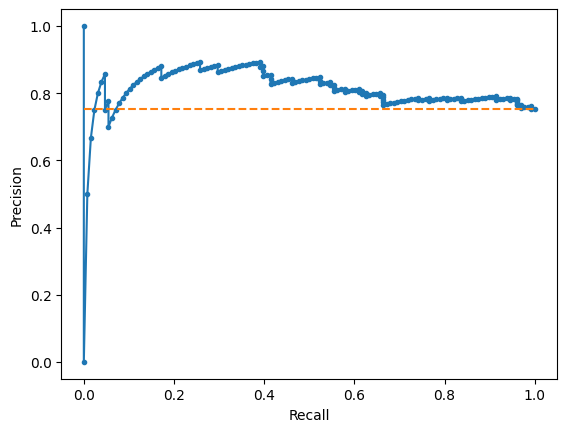

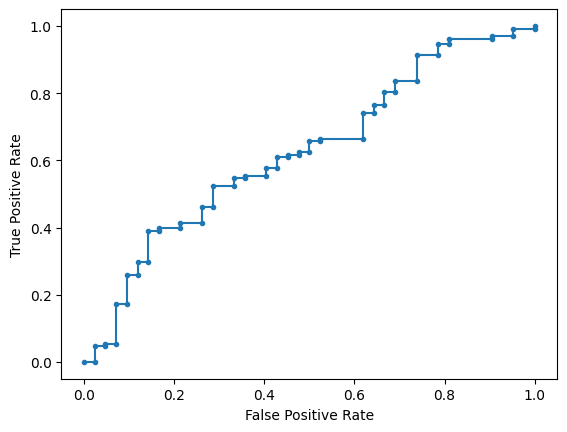

Accuracy: 75.29% Precision: 75.29% Recall: 100.00%
F1: 85.91% MCC: 0.0000
AUPRC: 81.14% AUROC: 62.56%
 accuracy [75.29411764705883]
 precision [75.29411764705883]
 recall [100.0]
 F1 [85.90604026845638]
 MCC [0.0]
 AUPRC [81.13809151491793]
 AUROC [62.55580357142857]
 accuracy mean 75.29% std nan
 precision mean 75.29% std nan
 recall mean 100.00% std nan
 F1 mean 85.91% std nan
 MCC mean 0.0000 std nan
 AUPRC mean 81.14% std nan
 AUROC mean 62.56% std nan
 accuracy [[75.29411764705883]]
 precision [[75.29411764705883]]
 recall [[100.0]]
 F1 [[85.90604026845638]]
 MCC [[0.0]]
 AUPRC [[81.13809151491793]]
 AUROC [[62.55580357142857]]

2023-04-19 17:49:09.403328
Cell Line 11 SK.N.SH
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1819
Num RCI: 1819
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1819 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 471
Num RCI: 471
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 471 sequences.

Training # 1 1
2023-04-19 17:49:13.709858
2023-04-19 17:49:13.709928
Discriminator is GMM
Means [-3.110502675077478, -0.1125226175752773]
Variances [2.93675041 2.05941152]
Priors [0.4263897 0.5736103]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 1099:720 60.42%
Computed class weights: {0: 1.2631944444444445, 1: 0.8275705186533212}
FIT
2023-04-19 17:49:14.742860


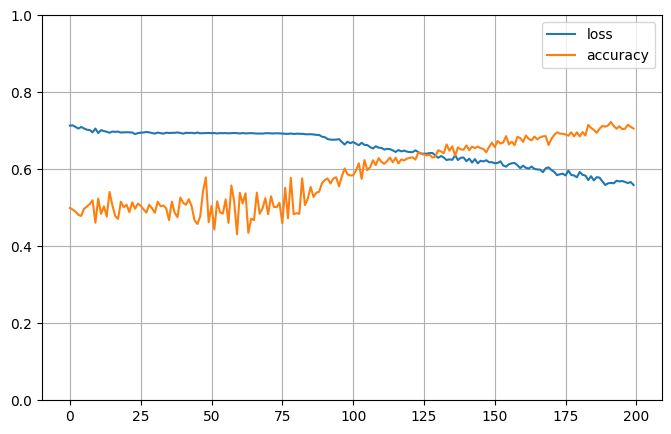


Testing # 1 1
2023-04-19 17:50:38.198065
2023-04-19 17:50:38.198120
PREDICT
2023-04-19 17:50:38.205317
Test 1:0 287:184 60.93%
Predict 1:0 361:110 76.65%
Test sizes (471, 1025) (471,)
Distrib of scores: 0.64027995 mean 0.20057103 std
Range of scores: 0.016499585 to 0.95588493
Score threshold 0.5
Confusion matrix
 [[ 65 119]
 [ 45 242]]
Normalized matrix
 [[0.13800425 0.25265393]
 [0.0955414  0.51380042]]
Extreme scores correct, pos:neg 196 36
Extreme scores incorrect pos:neg 79 18


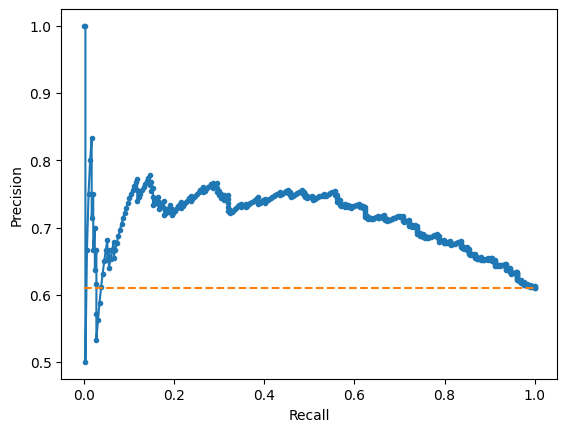

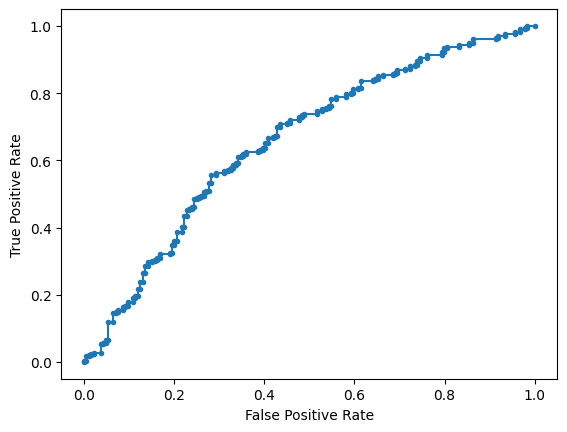

Accuracy: 65.18% Precision: 67.04% Recall: 84.32%
F1: 74.69% MCC: 0.2266
AUPRC: 71.19% AUROC: 65.76%
 accuracy [65.18046709129511]
 precision [67.03601108033241]
 recall [84.3205574912892]
 F1 [74.69135802469135]
 MCC [0.22656264279901075]
 AUPRC [71.18811552728585]
 AUROC [65.7570822602636]
 accuracy mean 65.18% std nan
 precision mean 67.04% std nan
 recall mean 84.32% std nan
 F1 mean 74.69% std nan
 MCC mean 0.2266 std nan
 AUPRC mean 71.19% std nan
 AUROC mean 65.76% std nan
 accuracy [[65.18046709129511]]
 precision [[67.03601108033241]]
 recall [[84.3205574912892]]
 F1 [[74.69135802469135]]
 MCC [[0.22656264279901075]]
 AUPRC [[71.18811552728585]]
 AUROC [[65.7570822602636]]

2023-04-19 17:50:38.844035
Cell Line 12 GM12878
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1905
Num RCI: 1905
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.ca

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1905 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 473
Num RCI: 473
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 473 sequences.

Training # 1 1
2023-04-19 17:50:43.226715
2023-04-19 17:50:43.227235
Discriminator is GMM
Means [-0.29013189403629913, -2.3434539157930314]
Variances [1.26135704 2.16066452]
Priors [0.57998355 0.42001645]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 1205:700 63.25%
Computed class weights: {0: 1.3607142857142858, 1: 0.7904564315352697}
FIT
2023-04-19 17:50:47.088867


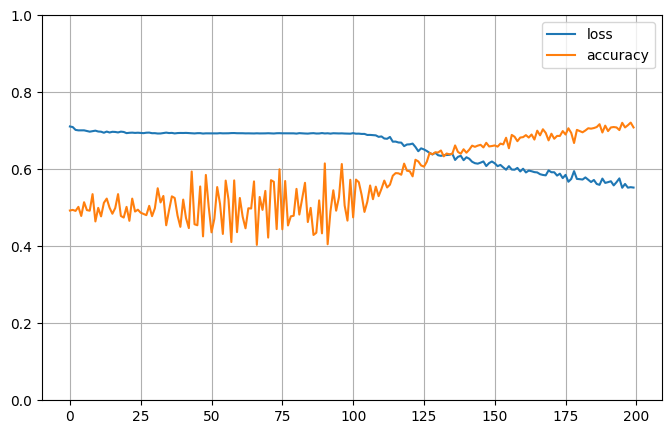


Testing # 1 1
2023-04-19 17:51:53.654789
2023-04-19 17:51:53.655442
PREDICT
2023-04-19 17:51:53.660794
Test 1:0 293:180 61.95%
Predict 1:0 318:155 67.23%
Test sizes (473, 1025) (473,)
Distrib of scores: 0.5977309 mean 0.21679068 std
Range of scores: 0.021345602 to 0.9652352
Score threshold 0.5
Confusion matrix
 [[ 92  88]
 [ 63 230]]
Normalized matrix
 [[0.19450317 0.18604651]
 [0.13319239 0.48625793]]
Extreme scores correct, pos:neg 171 52
Extreme scores incorrect pos:neg 51 26


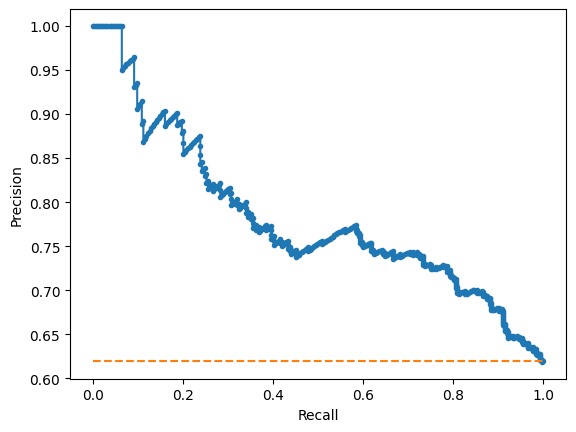

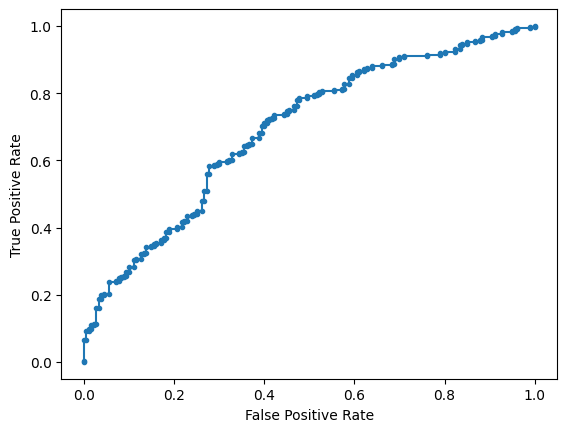

Accuracy: 68.08% Precision: 72.33% Recall: 78.50%
F1: 75.29% MCC: 0.3063
AUPRC: 78.21% AUROC: 69.21%
 accuracy [68.07610993657505]
 precision [72.32704402515722]
 recall [78.49829351535837]
 F1 [75.28641571194763]
 MCC [0.3062811919175052]
 AUPRC [78.20846446108057]
 AUROC [69.2055365946151]
 accuracy mean 68.08% std nan
 precision mean 72.33% std nan
 recall mean 78.50% std nan
 F1 mean 75.29% std nan
 MCC mean 0.3063 std nan
 AUPRC mean 78.21% std nan
 AUROC mean 69.21% std nan
 accuracy [[68.07610993657505]]
 precision [[72.32704402515722]]
 recall [[78.49829351535837]]
 F1 [[75.28641571194763]]
 MCC [[0.3062811919175052]]
 AUPRC [[78.20846446108057]]
 AUROC [[69.2055365946151]]

2023-04-19 17:51:54.697781
Cell Line 13 K562
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1040
Num RCI: 1040
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 1040 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 293
Num RCI: 293
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 293 sequences.

Training # 1 1
2023-04-19 17:51:58.988505
2023-04-19 17:51:58.988595
Discriminator is GMM
Means [-2.542607097137772, -0.15509047641157286]
Variances [1.69215773 1.3992858 ]
Priors [0.35126026 0.64873974]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 708:332 68.08%
Computed class weights: {0: 1.5662650602409638, 1: 0.7344632768361582}
FIT
2023-04-19 17:51:59.782213


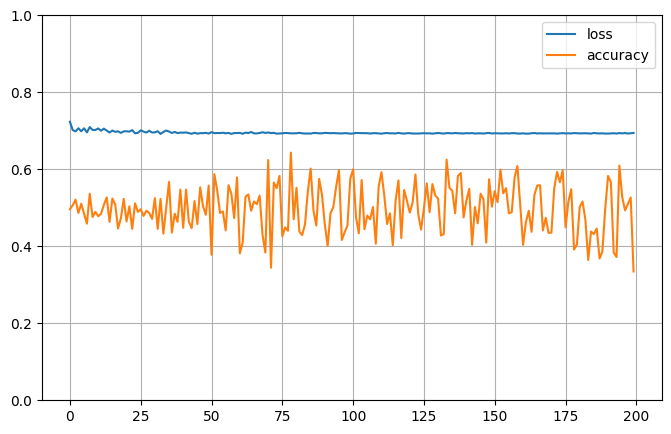


Testing # 1 1
2023-04-19 17:52:36.672108
2023-04-19 17:52:36.672432
PREDICT
2023-04-19 17:52:36.675386
Test 1:0 202:91 68.94%
Predict 1:0 0:293  0.00%
Test sizes (293, 1025) (293,)
Distrib of scores: 0.49687752 mean 0.00011390701 std
Range of scores: 0.4965541 to 0.49718958
Score threshold 0.5
Confusion matrix
 [[ 91   0]
 [202   0]]
Normalized matrix
 [[0.3105802 0.       ]
 [0.6894198 0.       ]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


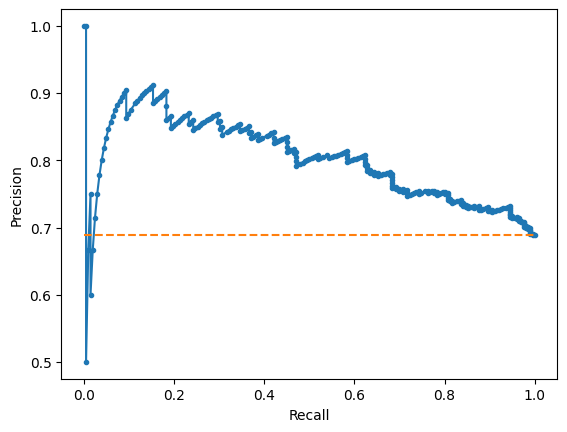

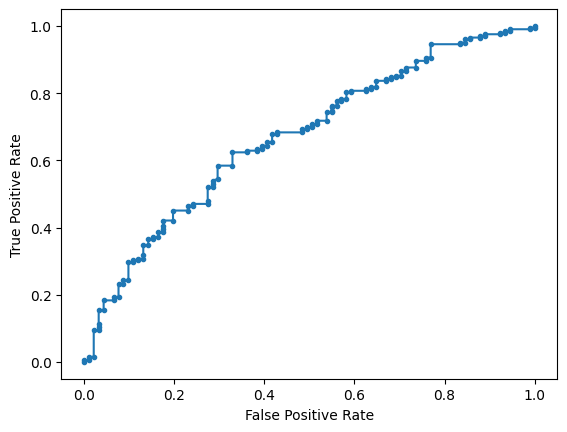

Accuracy: 31.06% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.0000
AUPRC: 80.13% AUROC: 67.06%
 accuracy [31.058020477815703]
 precision [0.0]
 recall [0.0]
 F1 [0.0]
 MCC [0.0]
 AUPRC [80.1344792671204]
 AUROC [67.06288760744205]
 accuracy mean 31.06% std nan
 precision mean 0.00% std nan
 recall mean 0.00% std nan
 F1 mean 0.00% std nan
 MCC mean 0.0000 std nan
 AUPRC mean 80.13% std nan
 AUROC mean 67.06% std nan
 accuracy [[31.058020477815703]]
 precision [[0.0]]
 recall [[0.0]]
 F1 [[0.0]]
 MCC [[0.0]]
 AUPRC [[80.1344792671204]]
 AUROC [[67.06288760744205]]

2023-04-19 17:52:37.621369
Cell Line 14 IMR.90
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 441
Num RCI: 441
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loaded 441 sequences.
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 108
Num RCI: 108
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/test.canon_lncRNA_transcripts.csv
Loaded 108 sequences.

Training # 1 1
2023-04-19 17:52:40.082095
2023-04-19 17:52:40.082532
Discriminator is GMM
Means [0.5571993348107099, -2.637371770764905]
Variances [1.43718009 3.26957451]
Priors [0.60070245 0.39929755]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 282:159 63.95%
Computed class weights: {0: 1.3867924528301887, 1: 0.7819148936170213}
FIT
2023-04-19 17:52:41.518104


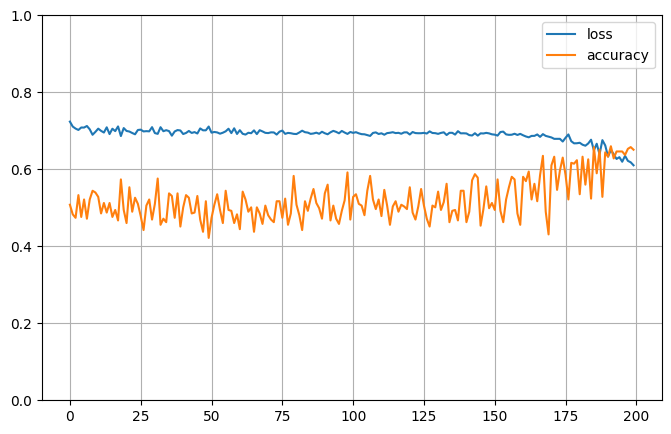


Testing # 1 1
2023-04-19 17:52:58.825304
2023-04-19 17:52:58.825350
PREDICT
2023-04-19 17:52:58.826674
Test 1:0 68:40 62.96%
Predict 1:0 66:42 61.11%
Test sizes (108, 1025) (108,)
Distrib of scores: 0.5581107 mean 0.124925785 std
Range of scores: 0.28054455 to 0.8894147
Score threshold 0.5
Confusion matrix
 [[24 16]
 [18 50]]
Normalized matrix
 [[0.22222222 0.14814815]
 [0.16666667 0.46296296]]
Extreme scores correct, pos:neg 25 1
Extreme scores incorrect pos:neg 3 1


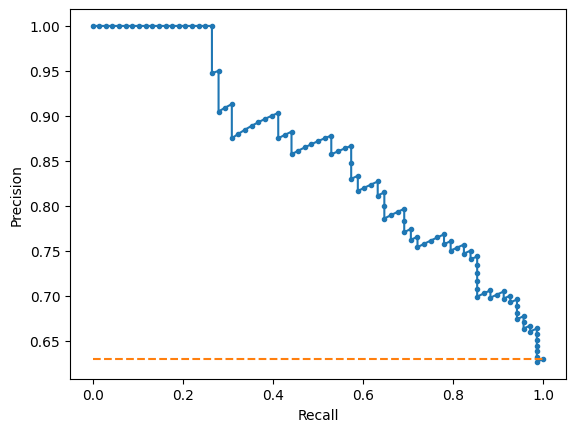

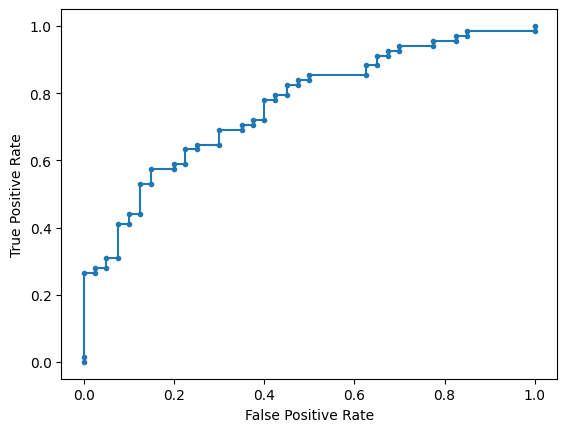

Accuracy: 68.52% Precision: 75.76% Recall: 73.53%
F1: 74.63% MCC: 0.3321
AUPRC: 85.59% AUROC: 76.36%
 accuracy [68.51851851851852]
 precision [75.75757575757575]
 recall [73.52941176470588]
 F1 [74.6268656716418]
 MCC [0.3321343345629432]
 AUPRC [85.588482041561]
 AUROC [76.36029411764707]
 accuracy mean 68.52% std nan
 precision mean 75.76% std nan
 recall mean 73.53% std nan
 F1 mean 74.63% std nan
 MCC mean 0.3321 std nan
 AUPRC mean 85.59% std nan
 AUROC mean 76.36% std nan
 accuracy [[68.51851851851852]]
 precision [[75.75757575757575]]
 recall [[73.52941176470588]]
 F1 [[74.6268656716418]]
 MCC [[0.3321343345629432]]
 AUPRC [[85.588482041561]]
 AUROC [[76.36029411764707]]
2023-04-19 17:52:59.933743


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
for cell_line in range(15):
    print()
    print(datetime.now())
    print('Cell Line',cell_line,all_cell_lines[cell_line])

    accuracy=[]
    precision=[]
    recall=[]
    f1=[]
    mcc=[]
    auprc=[]
    auroc=[]

    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TRAIN
    print("Load RCI from",filepath)
    gene_to_rci = loader.load_gene_rci_values(filepath,cell_line)
    print('Num RCI:', len(gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TRAIN
    print('Load sequence from',filepath)
    allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
    print('Loaded',len(allseq),'sequences.')
    test_gene_to_rci = None
    test_allids = None
    test_allseq = None
    if SEQ_FILE_TEST is not None:
        # Train on the entire train set (no cross-validation).
        # Evaluate with the test files.
        test_loader = DataLoader()
        filepath = DATA_DIR+RCI_FILE_TEST
        print("Load RCI from",filepath)
        test_gene_to_rci = test_loader.load_gene_rci_values(filepath,cell_line)
        print('Num RCI:', len(test_gene_to_rci.keys()))
        filepath = DATA_DIR+SEQ_FILE_TEST
        print('Load sequence from',filepath)
        test_allids,test_allseq = test_loader.load_spectra(filepath)
        print('Loaded',len(test_allseq),'sequences.')

    for repeat in range(REPEATS):
        for fold in range(FOLDS):
            show_r = repeat+1  # display one-based counting
            show_f = fold+1    # display one-based counting

            print()
            print("Training #",show_r,show_f)
            print(datetime.now())
            cvdo = CrossValidator(EPOCHS)
            cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
            if SEQ_FILE_TEST is None:
                # Train on 80% and evaluate on 20%.
                separator = Separator()
                separator.load(DATA_DIR,show_r,show_f)
                separator.process(allids,allseq,gene_to_rci)
                train_allids,test_allids = separator.get_ids()
                train_allseq,test_allseq = separator.get_seq()
                train_gene_to_rci,test_gene_to_rci = separator.get_rci()
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    test_allids,test_allseq,test_gene_to_rci)
                if SAVE_MODEL_FILENAME is not None:
                    filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                    cvdo.save_model(filename)
            else:
                # Train on the entire train set (no cross-validation).
                # Evaluate with the test files.
                train_allids = allids
                train_allseq = allseq
                train_gene_to_rci = gene_to_rci
                BREAK = True
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    None,None,None)

            print()
            print("Testing #",show_r,show_f)
            print(datetime.now())
            cvdo.reset_statistics()
            cvdo.test_without_training(
                test_allids,test_allseq,test_gene_to_rci)
            cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
                cvdo.get_statistics()

            print(" accuracy" ,  cv_accuracy)
            print(" precision" , cv_precision)
            print(" recall" ,    cv_recall)
            print(" F1" ,        cv_f1)
            print(" MCC" ,       cv_mcc)
            print(" AUPRC" ,     cv_auprc)
            print(" AUROC" ,     cv_auroc)

            accuracy.append(cv_accuracy)
            precision.append(cv_precision)
            recall.append(cv_recall)
            f1.append(cv_f1)
            mcc.append(cv_mcc)
            auprc.append(cv_auprc)
            auroc.append(cv_auroc)
            if BREAK: break
        if BREAK: break

    print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
    print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
    print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
    print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
    print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
    print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
    print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

    print(" accuracy"  , accuracy)
    print(" precision" , precision)
    print(" recall"    , recall)
    print(" F1"        , f1)
    print(" MCC"       , mcc)
    print(" AUPRC"     , auprc)
    print(" AUROC"     , auroc)
print(datetime.now())